# Db2 Warehouse IoT demo 
# Structured Streaming with Apache Kafka and PySpark 


This is a demo notebook for Db2 Warehouse's integrated Apache Spark environment and how it can be used to process and land streaming data in Db2 tables. It runs through livy with a PySpark kernel.

If you are new to Db2 Warehouse and its integrated Apache Spark capabilities you may first want to check out this [overview article](http://www.ibmbigdatahub.com/blog/evolving-enterprise-data-warehouse-beyond-sql-apache-spark). For more details about structured streaming and Kafka integration, please follow this [link](https://spark.apache.org/docs/2.3.0/structured-streaming-kafka-integration.html#deploying).

![](https://ibm.box.com/shared/static/6dr6gou6xr1alfwnj6zkj0tbsyc64vda.png)

## Set up IoT demo data producer
This demo relies on a little data producer container that you have to set up on the same host as your Db2 Warehouse container. You can find it [here](https://github.com/ibmdbanalytics/dashdb_analytic_tools/tree/notebook-dev/dashdblocal_notebooks/iot_producer) in a sub folder of the dashDB Jupyter notebook container project. Please follow the instructions found there and perform the few simple steps to set it up. 

This producer will set up a Kafka server on port `9092` with a Kafka topic named `iot4dashdb` and permanently flow in there messages about wind turbine device measurements.

## Streaming environment setup for Spark

__Imports__

In [1]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import from_json
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, LongType, TimestampType

from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from ast import literal_eval
import json

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
17,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Define a Spark session__

In [2]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Kafka for structured streaming__

Let's check if you have the Kafka stream library available. If this is not the case you should download it, put it into the ~/spark/defaultlibs directory and restart the notebook. Same for the Spark SQL Kafka library.

In [3]:
import os
path = os.getenv("HOME") + "/spark/defaultlibs"

kafka_assembly = "spark-streaming-kafka-0-10-assembly_2.11-2.3.0.jar"
url = "http://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-10-assembly_2.11/2.3.0/" + kafka_assembly

if (os.path.exists(path + "/" + kafka_assembly)):
    print("Kafka assembly found")
else:
    os.system("wget -nv -P " + path + " " + url)
    print ("Kafka assembly downloaded. Please restart the notebook")
    
kafka_sql = "spark-sql-kafka-0-10_2.11-2.3.0.jar"
url = "http://repo1.maven.org/maven2/org/apache/spark/spark-sql-kafka-0-10_2.11/2.3.0/" + kafka_sql

if (os.path.exists(path + "/" + kafka_sql)):
    print("Kafka sql library found")
else:
    os.system("wget -nv -P " + path + " " + url)
    print ("Kafka sql library downloaded. Please restart the notebook")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Kafka assembly found
Kafka sql library found

__Streaming queries to access data from our iotproducer__

Here we subscribe to the topic `iot4dashdb` with structure streaming. The dsraw dataframe will collect data flowing from the iotproducer until this notebook is shut down or the iotproducer stops. Neither a timeout nor the `awaitTermination` option are needed here.

In [4]:
topic = "iot4dashdb"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
dsraw = sparkSession \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("subscribe", topic) \
  .option("startingOffsets", "earliest").load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
dsraw.printSchema() 

# typical schema for a streaming dataset.
# particular features are contained in the field "value"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

dsraw is the raw data stream in "kafka" format, where the data type of the "key" and "value" columns is binary. The "value" column contains the data generated by the wind turbines. We cast its data type to string to be able to read its values. 
ds is the data frame with this column.
Note: ds stands for "data stream". Both are dataframes. 

In [7]:
ds = dsraw.selectExpr("CAST(value AS STRING)")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
print(type(dsraw))
print(type(ds)) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>

In [9]:
ds.printSchema() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- value: string (nullable = true)

## Data exploration 

We will collect streaming data by using some queries which will read data from the stream. We explore this data: which features did we actually collect in the value field? Then we go through a few data processing steps in order to obtain a clean Spark DataFrame which we will finally write into a Db2 table.

**Important note:** Before running the queries, make sure that the iotproducer is active. You can print the messages sent by the container by running the following commmand: 

> docker exec -it iotproducer kafka/bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic iot4dashdb --from-beginning

For more details, please refer to the [iotproducer set-up document](https://github.com/ibmdbanalytics/dashdb_analytic_tools/tree/master/dashdblocal_notebooks/iot_producer).

**Queries**

Queries are new SQL dataframe streams and can be written to disk or saved to memory for follow-up SQL operations. Below we save two queries to memory with queryNames that can then be treated as tables by `spark.sql`.

In [10]:
### QUERIES ### 
# Here without timeout, just to take a look at the data in order to:
# - check if our set-up is working
# - see how the data actually looks like (schema inside value field)

timeout = 10

# on raw data
rawQuery = dsraw \
        .writeStream \
        .queryName("qraw")\
        .format("memory")\
        .start()

# on actual values
turbineQuery = ds \
        .writeStream \
        .queryName("qturbine")\
        .format("memory")\
        .start()

rawQuery.awaitTermination(timeout=timeout)
turbineQuery.awaitTermination(timeout=timeout)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

False

In [11]:
# Stopping the queries... otherwise they would run undefinitely!
rawQuery.stop()
turbineQuery.stop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Raw data
raw = sparkSession.sql("select * from qraw")
raw.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     0|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     1|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     2|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     3|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     4|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     5|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     6|2019-12-19 15:32:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     7|2019-12-19 15:32:...|            0|

In [13]:
# Values only
turbine = sparkSession.sql("select value from qturbine")
turbine.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"payload": {"temperature": 30,"tempOutside": 18,"powerProd": 1828,"noiseLevel1": 82,"time":"2019-12-19 15:32:24"},"deviceId": "2706","deviceType": "windGen","eventType": "status"}|
|{"payload": {"temperature": 37,"tempOutside": 18,"powerProd": 1827,"noiseLevel1": 82,"time":"2019-12-19 15:32:26"},"deviceId": "2704","deviceType": "windGen","eventType": "status"}|
|{"payload": {"temperature": 34,"tempOutside": 18,"powerProd": 1831,"noiseLevel1": 82

Let's take a closer look at our data:
As you have noticed, the features are in a nested format. We need to flatten the schema before saving the data into a Db2 table.

In [14]:
# We can now define a proper schema

schema = StructType([StructField("payload", 
                                StructType([StructField("temperature", LongType()),
                                            StructField("tempOutside", LongType()),
                                            StructField("powerProd", LongType()),
                                            StructField("noiseLevel1", LongType()),
                                            StructField("time", StringType())])), # should be TimestampType
                    StructField("deviceId", StringType()),
                    StructField("deviceType", StringType()),
                    StructField("eventType", StringType())])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__New query: collect parsed data in batches__

In the cell bellow we use a while loop to collect `maxcount` records from the datastream. Data is collected in batches. The size of a batch can vary: it is the duration which we set with the `timeout` variable.

In [15]:
maxcount = 20
count = 0
topic="iot4dashdb"
startingOffsets = "latest"
timeout = 10


while count < maxcount:
    parsed = sparkSession \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "localhost:9092") \
      .option("subscribe", topic) \
      .option("startingOffsets", startingOffsets) \
      .load() \
      .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
    # on parsed data
    pQuery = parsed \
        .writeStream \
        .queryName("qparsed")\
        .format("memory")\
        .start()
    if not pQuery.awaitTermination(timeout=timeout):
        pQuery.stop() 
    turbineP = sparkSession.sql("select * from qparsed")
    full_turbineP = turbineP.select(["parsed_value.payload.temperature", "parsed_value.payload.tempOutside", "parsed_value.payload.powerProd", "parsed_value.payload.noiseLevel1", "parsed_value.payload.time", "parsed_value.deviceId", "parsed_value.deviceType", "parsed_value.eventType"])
    full_turbineP.show()
    startingOffset = str(pQuery.lastProgress['sources'][0]['startOffset']).replace("\'", "\"")
    print("Starting offset for next batch: " + startingOffset)
    count = count + turbineP.count() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|temperature|tempOutside|powerProd|noiseLevel1|               time|deviceId|deviceType|eventType|
+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|         33|         18|     1834|         82|2019-12-19 16:54:31|    2708|   windGen|   status|
|         33|         18|     1829|         82|2019-12-19 16:54:33|    2704|   windGen|   status|
|         37|         18|     1833|         82|2019-12-19 16:54:34|    2709|   windGen|   status|
|         31|         18|     1831|         82|2019-12-19 16:54:36|    2700|   windGen|   status|
|         38|         18|     1828|         82|2019-12-19 16:54:38|    2704|   windGen|   status|
+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+

Starting offset for next batch: {"iot4dashdb": {"0": 2556}}
+-----------+-----------+---------+-----------+----------

## Write IoT records to a persistent Db2 table

In [16]:
maxcount = 40
count = 0
topic="iot4dashdb"
startingOffsets = "latest"
timeout = 10
tableName= "USERDATA.IOT_EVENTS"
savemode = 'overwrite'

while count < maxcount:
    parsed = sparkSession \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "localhost:9092") \
      .option("subscribe", topic) \
      .option("startingOffsets", startingOffsets) \
      .load() \
      .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
    # on parsed data
    pQuery = parsed \
        .writeStream \
        .queryName("qparsed")\
        .format("memory")\
        .start()
    if not pQuery.awaitTermination(timeout=timeout):
        pQuery.stop() 
    turbineP = sparkSession.sql("select * from qparsed")
    full_turbineP = turbineP.select(["parsed_value.payload.temperature", "parsed_value.payload.tempOutside", "parsed_value.payload.powerProd", "parsed_value.payload.noiseLevel1", "parsed_value.payload.time", "parsed_value.deviceId", "parsed_value.deviceType", "parsed_value.eventType"])
    count = count + turbineP.count() 
    full_turbineP.write.format("com.ibm.idax.spark.idaxsource") \
        .option("dbtable", tableName ) \
        .option("allowAppend", "TRUE") \
        .mode(savemode).save()
    savemode = "append"
    print(str(turbineP.count()) + " rows read from stream and written into database table")
    startingOffset = str(pQuery.lastProgress['sources'][0]['startOffset']).replace("\'", "\"")
    print("Starting offset for next batch: " + startingOffset)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2582}}
5 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2590}}
6 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2596}}
6 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2602}}
5 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2607}}
5 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2613}}
5 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2619}}
5 rows read from stream and written into database table
Starting offset for next batch: {"iot4dashdb": {"0": 2625}}

In [17]:
df_check = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable=tableName) \
        .load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
print("Total IoT Records: "+ str(df_check.count()))
print("Showing Newest "+ str(df_check.count()) +" Records:")
df_check.select("deviceId", "time", "temperature", "tempOutside", "powerProd", "noiseLevel1").\
                orderBy("time", ascending=False).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total IoT Records: 42
Showing Newest 42 Records:
+--------+-------------------+-----------+-----------+---------+-----------+
|deviceId|               time|temperature|tempOutside|powerProd|noiseLevel1|
+--------+-------------------+-----------+-----------+---------+-----------+
|    2703|2019-12-19 16:56:44|         36|         18|     1836|         82|
|    2707|2019-12-19 16:56:42|         34|         18|     1831|         82|
|    2704|2019-12-19 16:56:40|         37|         18|     1830|         82|
|    2707|2019-12-19 16:56:38|         36|         18|     1828|         82|
|    2709|2019-12-19 16:56:37|         37|         18|     1832|         82|
|    2701|2019-12-19 16:56:33|         38|         18|     1830|         82|
|    2709|2019-12-19 16:56:31|         38|         18|     1829|         82|
|    2700|2019-12-19 16:56:29|         32|         18|     1827|         82|
|    2700|2019-12-19 16:56:27|         34|         18|     1835|         82|
|    2707|2019-12-19 16:56:

## Visualisation of time series

You may want to visualize the data you are collecting. Let's plot some of the features over time.

In [19]:
%local

%matplotlib inline

#Useful imports for local visualisations
import pandas as pd
import matplotlib.pyplot as plt

__Note : Make a bridge between remote and local__

So far we've been using Spark servers and the data is accessed remotely. If we plot visualisations now, they won't appear right on your screen : you will have to fetch them, using their adress, to open them locally. So for convenience, visualisations will be made locally thanks to the __%local__ magic. Therefore, we need to create a temporary view of the data, and query it with the %%sql magic in order to access it locally and plot it directly. Note that the data on the Spark cluster is a Spark dataframe, whereas the data we handle locally is a Pandas dataframe.

In the following cells, we will:
1. Create a SQL temporary view of the tornado (Spark) dataframe
2. Run a %%sql cell magic to query the data, and output it to the local space. The table is now seen as a Pandas dataframe.
3. We use this Pandas dataframe to make our graphs, which we output locally.

In [20]:
df_check.createOrReplaceTempView('turbine')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%sql -o turbine --maxrows -1
SELECT * FROM turbine

In [22]:
%local

# convert "time" column back into timestamps
turbine['time']=pd.to_datetime(turbine['time'])

# select the device you want to focus on
print(turbine['deviceId'].unique())

deviceID = 2704 #your choice

device=turbine[turbine['deviceId']== deviceID] 


[2706 2702 2701 2704 2703 2700 2705 2709 2708 2707]


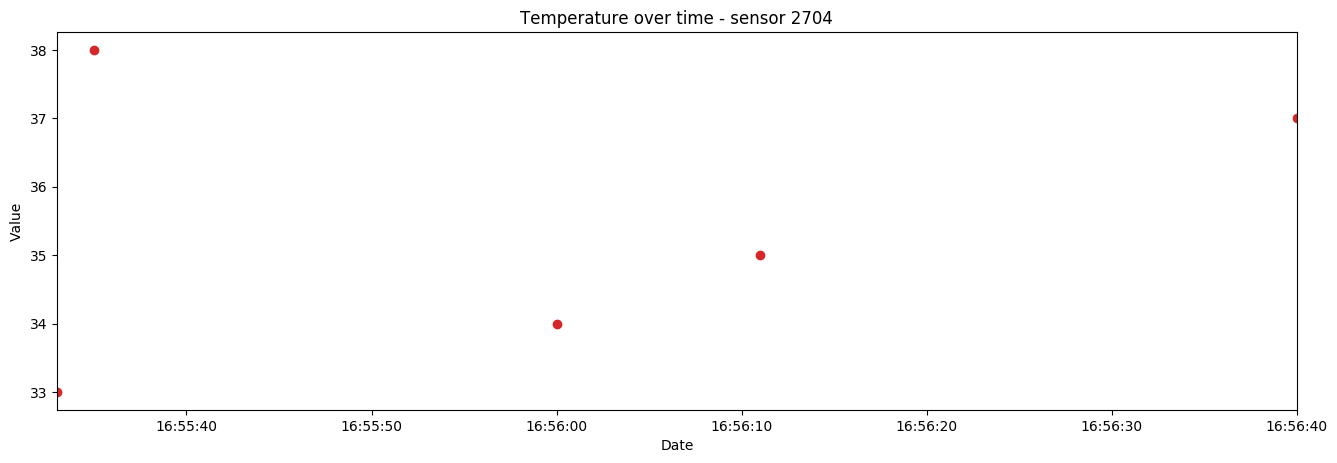

In [23]:
%local

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Basic plot

fig, ax = plt.subplots(figsize=(16,5), dpi=100)

x = device.set_index('time').index
first = min(x)
last = max(x)

y=device.temperature 
xlabel='Date'
ylabel='Value'
title='Temperature over time - sensor '+str(deviceID)

plt.scatter(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
ax.set_xlim(first, last)

plt.show()   

It could be useful to compare the temperature measured by the sensor with the power production over time. Is the temperature raising over time? Does an increase in power production implies an increase in temperature? With some lag?

Note that the data generator we used here doesn't provide very meaningful data regarding Physics... Furthermore, we would need a far longer observation time to make any conclusion. However, the following visualisations are provided for the sake of our use case.

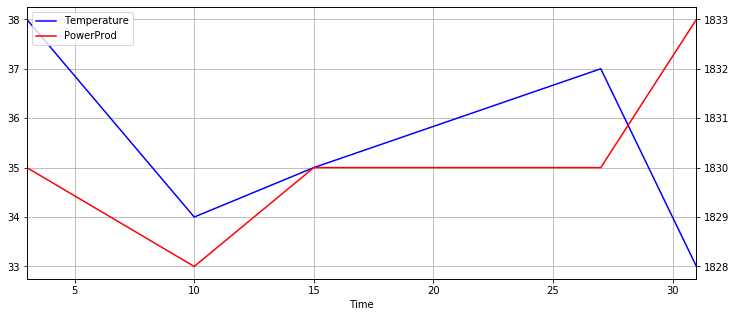

In [24]:
%local

# Temperature and power production over time 
# in a particular sensor

plt.figure(figsize=(12,5))
plt.xlabel('Time')

ax1 = device.temperature.plot(color='blue', grid=True, label='Temperature')
ax2 = device.powerProd.plot(color='red', grid=True, secondary_y=True, label='PowerProd')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()